In [1]:
!pip install wandb

In [2]:
#IMPORTS put all here
import random
import matplotlib.pyplot as plt

#tf imports for reading file
import numpy as np
import os
import PIL

import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


#extras
print(tf.__version__)
import pathlib
import shutil

2022-11-05 21:03:59.974973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 21:03:59.974987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ayushsingh/anaconda3/envs/ai_ml_nn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.8.0


In [3]:
# # wandb
# import wandb

# wandb.init(project="GuessFlatKNN")


In [4]:
#path to image dataset
spec_path = 'content/spectrograms6sec'

genre_list=os.listdir(spec_path)
genre_list


['indian_indie',
 'hindustani_classical',
 'classic_bollywood',
 'carnatic',
 'desi_pop',
 'tamil_pop',
 'punjabi_hip_hop',
 'ghazal',
 'sufi',
 'bhojpuri_pop']

In [5]:
#resets the experiment
%rm -rf content/spectrograms6secnew

In [6]:
os.mkdir('content/spectrograms6secnew')
dest_path='content/spectrograms6secnew'

for genre in genre_list:
  os.mkdir(f'content/spectrograms6secnew/{genre}')

In [7]:


#no of samples per class
n=3000
cnt=0

random.seed(123)

for genre in genre_list:
  genre_path=os.path.join(spec_path,genre)
  dest_genre_path=os.path.join(dest_path,genre)

  #shuffling and selecting 3000 samples
  genre_songs=os.listdir(genre_path)
  random.shuffle(genre_songs)
  selected_spec=genre_songs[:n]
  
  for song in selected_spec:
      source=os.path.join(genre_path,song)
      dest=os.path.join(dest_genre_path,song)
      d= shutil.copyfile(source, dest)




In [8]:
data_dir=pathlib.Path(dest_path)
data_dir

PosixPath('content/spectrograms6secnew')

In [9]:
#adding dataset
batch_size=64
image_height=100
image_width=200


In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.


2022-11-05 21:04:09.320482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-05 21:04:09.320516: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-05 21:04:09.320533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (CoderCatA5Pop): /proc/driver/nvidia/version does not exist
2022-11-05 21:04:09.320886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 30000 files belonging to 10 classes.
Using 6000 files for validation.


['bhojpuri_pop', 'carnatic', 'classic_bollywood', 'desi_pop', 'ghazal', 'hindustani_classical', 'indian_indie', 'punjabi_hip_hop', 'sufi', 'tamil_pop']


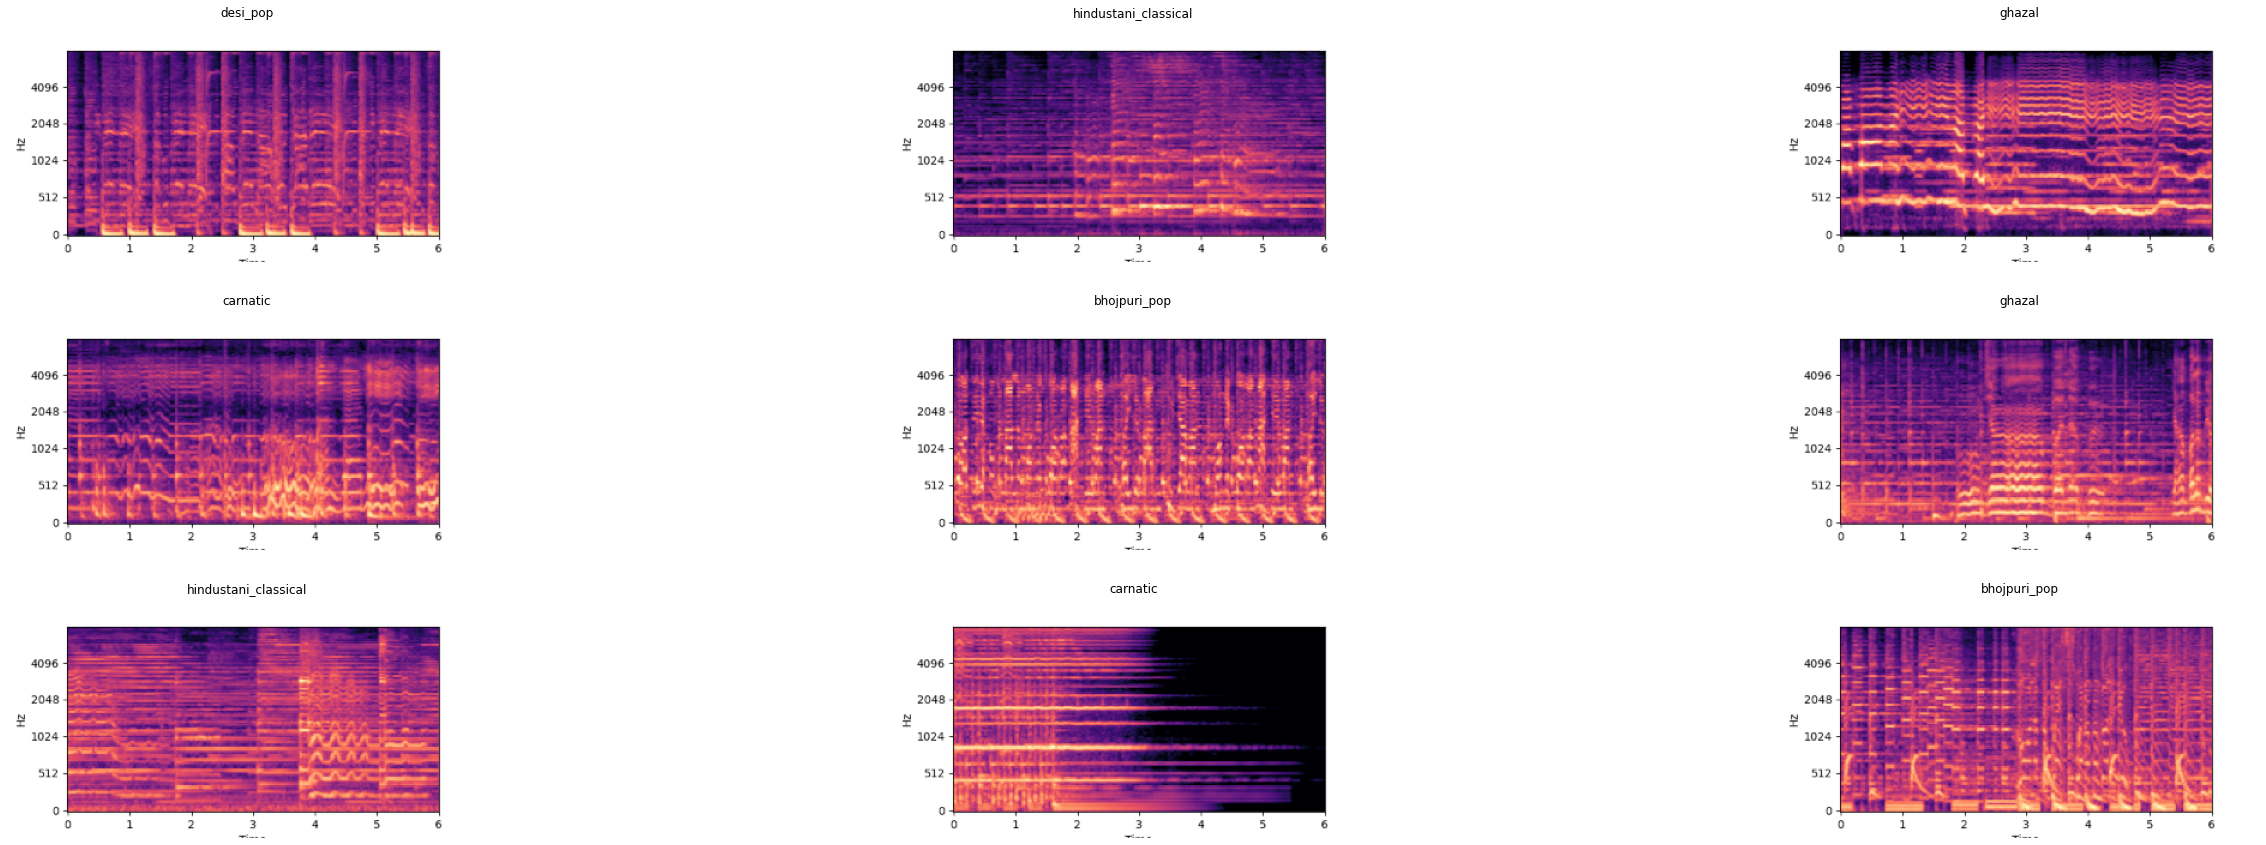

In [12]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(45, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 400, 3)
(32,)


In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

https://www.analyticsvidhya.com/blog/2021/06/build-an-image-classifier-with-svm/

In [16]:
num_classes = len(class_names)
from tensorflow.keras.regularizers import l2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.01),activation = "linear")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 100, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 100, 64)       1

In [19]:

# wandb.config = {
#   "epochs": 5,
#   "batch_size":32
# }

epochs=5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)
  



Epoch 1/5
367/750 [=============>................] - ETA: 5:05 - loss: 2.0176 - accuracy: 0.2995

: 

: 

In [ ]:
print(tf.summary)